This uses the results of running `RL_discrete_1q_space_v20_lambda.py` on lambda, and obtaining the files `optimal_policy_discrete_1q_v20.p` and `V_optimal_discrete_1q_v20.p`.

In [1]:
import gym
import gym.spaces
import numpy as np
from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
import sys
# from pyquil.api._base_connection import ForestConnection
import pickle

from collections import defaultdict
import sys

In [2]:
# identify discrete gates on qubit 0
num_angles = 1000
angles = np.linspace(0.0, 2 * np.pi, num_angles)
gates = [RY(theta, 0) for theta in angles]
gates += [RZ(theta, 0) for theta in angles]

In [3]:
class OneQEnv(gym.Env):
    
    def __init__(self, goal_angles, bins=(4, 8)):
        # WavefunctionSimulator
        self.wfn_sim = WavefunctionSimulator()
        # Identify discrete state space grid
        self._bins = bins
        self._grid = self.create_uniform_grid(bins=self._bins)
        # Identify desired state
        self.goal_angles = goal_angles
        self.goal_state = self.polar_angles_to_state(self.goal_angles)
        # Create rewards dictionary
        self.d_rewards = defaultdict(lambda: 0)
        self.d_rewards[self.goal_state] = 1
        # Identify discrete state space
        self.state_space = gym.spaces.Discrete((self._bins[0] - 2) * self._bins[1] + 2)
        self.observation_space = self.state_space
        # Identify discrete action space
        self._actions = gates
        self.action_space = gym.spaces.Discrete(len(self._actions))
        # Identify sizes of state and action spaces
        self.nS = self.state_space.n
        self.nA = self.action_space.n
        # Initialize to identity program
        self._program = Program(I(0))
        # Identify state
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks for polar angles
        assert self._theta >= 0.0 and self._theta <= np.pi
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi
        self.info = {}
        
        
    def reset(self, state=None):
        if state is None:
            state = np.random.choice(env.nS)
        assert state in range(env.nS), "Invalid state"
        angles = self.state_to_polar_angles(state)
        # consistency checks
        assert angles[0] >= 0.0 and angles[0] <= np.pi
        assert angles[1] >= 0.0 and angles[1] <= 2 * np.pi

        self.polar_angles_to_prog(angles)
        self.state = state
        return self.state


    def step(self, action):
        self._program += self._actions[action]
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = 0
            done = False

        return self.state, reward, done, self.info


    @classmethod
    def amps_to_polar_angles(self, z):
        # NOTE: This is a poorly named function
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        return r, angle
    
    
    @classmethod
    def amps_to_actual_polar_angles(self, z):
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        cos_theta_over_2 = np.abs(r[0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        theta = 2 * np.arccos(cos_theta_over_2)
        theta = theta % (np.pi)
        phi = angle[1] - angle[0]
        if phi < 0.0: phi += 2 * np.pi
        phi = phi % (2 * np.pi)
        return theta, phi


    def wfn_to_polar_angles(self):
        self._wfn = self.wfn_sim.wavefunction(self._program)
        self._wfn_amps = self._wfn.amplitudes
        self._wfn_polar = self.amps_to_polar_angles(self._wfn_amps)
        cos_theta_over_2 = np.abs(self._wfn_polar[0][0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        self._theta = 2 * np.arccos(cos_theta_over_2)
        if self._theta < 0.0: self._theta = -self._theta
        self._phi = self._wfn_polar[1][1] - self._wfn_polar[1][0]
        if self._phi < 0.0: self._phi += 2 * np.pi
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"


    def polar_angles_to_state(self, angles):
        discrete_sample = self.discretize(sample=angles, grid=self._grid)
        state_number = self.state_number(discrete_sample, mygrid=self._grid)
        return state_number


    def create_uniform_grid(self, bins):
        # create grid for angles
        low=[0.0, 0.0]
        high=[np.pi, 2 * np.pi]
        grid_list = []
        for i in range(len(low)):
            tmp_high = high[i]
            tmp_low = low[i]
            tmp_bin = bins[i]
            tmp_diff = (tmp_high - tmp_low) / tmp_bin
            tmp_arr = np.linspace(tmp_low + tmp_diff, tmp_high - tmp_diff, tmp_bin - 1)
            grid_list.append(tmp_arr)
        return grid_list
    
    
    def discretize(self, sample, grid):
        # Discretize a sample as per given grid.
        samps = []
        dims = len(grid)
        for i in range(dims):
            tmp_samp = np.digitize(np.round(sample[i], 2), np.round(grid[i], 2))
            samps.append(tmp_samp)

        samps = np.array(samps)
        assert samps.shape == (dims, )
        return samps


    def state_number(self, discrete_sample, mygrid):
        # expecting an array with 2 entries
        if discrete_sample[0] == 0:
            return 0
        elif discrete_sample[0] == self._bins[0] - 1:
            return (self._bins[0] - 2) * self._bins[1] + 1
        else:
            return (discrete_sample[0] - 1) * self._bins[1] + discrete_sample[1] + 1


    def state_to_polar_angles(self, state_num):
        assert state_num in range(self.nS)
        if state_num == 0:
            return 0.0, 0.0
        elif state_num == (self._bins[0] - 2) * self._bins[1] + 1:
            return np.pi, 0.0
        else:
            N = self._bins[0]
            M = self._bins[1]
            theta = (np.pi / N) * ((state_num - 1) // M + 1)
            theta = theta % (2 * np.pi)
            phi = (2 * np.pi / M) * ((state_num - 1) % M)
            phi = phi % (2 * np.pi)
            # consistency checks
            assert theta >= 0.0 and theta <= np.pi, f"theta: {theta}"
            assert phi >= 0.0 and phi <= 2 * np.pi, f"phi: {phi}"
            return theta, phi
    
    
    def polar_angles_to_prog(self, angles):
        theta = angles[0]
        phi = angles[1]
        self._program = Program(RY(theta, 0), RZ(phi, 0))

In [4]:
env = OneQEnv(goal_angles=np.array([np.pi, 0.0]), bins=(16, 32))
print(f"No. of states: {env.nS}")

No. of states: 450


In [5]:
optimal_policy = pickle.load(open('optimal_policy_discrete_1q_v20.p', 'rb'))

In [6]:
d_optimal_prog = {}

for s in range(env.nS):
    
    converged = False

    while not converged:

        original_state = env.reset(s)
        original_angles = env.state_to_polar_angles(s)
        original_wfn = env.wfn_sim.wavefunction(env._program)

        state = s
        prog = Program()
        done = False
        counter = 0
        converged = False

        while not done:
            action = np.argmax(optimal_policy[state])
            prog += env._actions[action]
            next_state, reward, done, info = env.step(action)
            state = next_state
            counter += 1
            if counter > 50:
                break
                
        if done:
            converged = True
            print(f"original state: {original_state}")
            print(f"Polar angles: {original_angles}")
            print(f"Original wavefunction: {original_wfn}")
            print("\n")
            d_optimal_prog[s] = prog
            print("Optimal program")
            print(prog)
            print("Final wavefunction")
            print(env._wfn)
            print("Final outcome probabilities")
            print(env._wfn.get_outcome_probs())
            print("*" * 30)

original state: 0
Polar angles: (0.0, 0.0)
Original wavefunction: (1+0j)|0>


Optimal program
RY(3.138447916198812) 0

Final wavefunction
(0.001572368+0j)|0> + (0.9999987638+0j)|1>
Final outcome probabilities
{'0': 2.472341277065505e-06, '1': 0.999997527658723}
******************************
original state: 1
Polar angles: (0.19634954084936207, 0.0)
Original wavefunction: (0.9951847267+0j)|0> + (0.0980171403+0j)|1>


Optimal program
RY(2.748500479717196) 0
RY(0.17610529389492333) 0

Final wavefunction
(0.0103184865+0j)|0> + (0.999946763+0j)|1>
Final outcome probabilities
{'0': 0.00010647116265682363, '1': 0.9998935288373432}
******************************
original state: 2
Polar angles: (0.19634954084936207, 0.19634954084936207)
Original wavefunction: (0.9903926402-0.097545161j)|0> + (0.097545161+0.0096073598j)|1>


Optimal program
RY(2.773658378845042) 0

Final wavefunction
(0.0852745552-0.0272892956j)|0> + (0.9915245284-0.0941416706j)|1>
Final outcome probabilities
{'0': 0.0080164554

In [7]:
prog_lengths = [len(v) for v in d_optimal_prog.values()]

(array([ 65.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 189.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 122.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  66.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
 <a list of 50 Patch objects>)

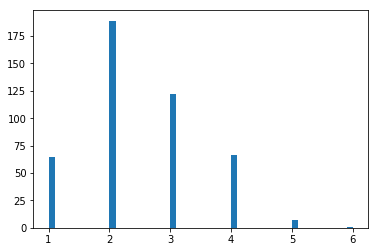

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(prog_lengths, bins=50)

### Analyze a single non-optimal "optimal" program

In [9]:
non_optimal_3 = [k for k, v in d_optimal_prog.items() if len(v) == 3]
len(non_optimal_3)

122

In [10]:
non_optimal_3[0]

35

In [13]:
print(d_optimal_prog[35])

RZ(2.3396846188896956) 0
RZ(0.18868424345884643) 0
RY(3.6101585248459283) 0



In [20]:
# In this case, the two RZs should be quite redundant
# what are the indices of `RZ(2.3396846188896956)` and `RZ(0.18868424345884643)` respectively?
# what is the index of their sum?

discr_angles = np.linspace(0.0, 2 * np.pi, 1000)
for i, angle in enumerate(discr_angles):
    if np.isclose(angle, 2.3396846188896956):
        print(f"angle: {angle}, index: {i}")
        print("\n")
    elif np.isclose(angle, 0.18868424345884643):
        print(f"angle: {angle}, index: {i}")
        print("\n")
    elif np.isclose(angle, 2.3396846188896956 + 0.18868424345884643):
        print("For the sum of the two angles")
        print(f"angle: {angle}, index: {i}")
        print("\n")

angle: 0.18868424345884643, index: 30


angle: 2.3396846188896956, index: 372


For the sum of the two angles
angle: 2.528368862348542, index: 402




In [23]:
# print(gates[1000 + 30])
# print(gates[1000 + 372])
# print(gates[1000 + 402])

print(gates[1030])
print(gates[1372])
print(gates[1402])

RZ(0.18868424345884643) 0
RZ(2.3396846188896956) 0
RZ(2.528368862348542) 0


In [26]:
import pickle

a = {'hello': 'world'}

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)

True


In [24]:
# from collections import defaultdict

# size_expt = 10000
# d_raw_counts = defaultdict(lambda: [])


# for expt in range(size_expt):
#     print(f"\rExperiment {expt+1} / {size_expt}", end="")
#     sys.stdout.flush()
#     u = np.random.uniform(0.0, 1.0, size=2)
#     theta = np.arccos(2 * u[0] - 1)
#     phi = 2 * np.pi * u[1]
#     angles = [theta, phi]
    
#     for a in range(env.nA):
#         env.reset()
#         env.polar_angles_to_prog(angles)   # sets env._program
#         s = env.polar_angles_to_state(angles)    # sets nothing; returns state number
#         next_s, reward, done, info = env.step(a)
#         d_raw_counts[s, a] += [next_s]

Experiment 3 / 10000

KeyboardInterrupt: 